In [1]:
import pandas as pd
import numpy as np
import sys

version = ".".join(map(str, sys.version_info[:3]))
print('python version ', version)
print('numpy version ', np.__version__)
print('pandas version ',pd.__version__)

python version  3.6.2
numpy version  1.13.1
pandas version  0.20.3


In [2]:
import geopandas as gpd
import pysal

print("geopandas version ", gpd.__version__)

geopandas version  0.2.1


In [3]:
import matplotlib.pyplot as plt

In [4]:
# Tell the kernel that we want the plots to be in this notebook
# and not in an external window
%matplotlib inline

### US State shapefile
We want the US states shapefile to be the bottom layer to help give the view geographic context.  Additional geographic context is given through city names and points.

In [5]:
cb_2015_us_state = '../../data/shapefiles/cb_2015_us_state_20m/cb_2015_us_state_20m.shp'
us_state_df = gpd.read_file(cb_2015_us_state)
us_state_df.head(3)

,AFFGEOID,ALAND,AWATER,GEOID,LSAD,NAME,STATEFP,STATENS,STUSPS,geometry
0,0400000US48,676634395761,19027462392,48,00,Texas,48,01779801,TX,"POLYGON ((-106.623445 31.914034, -106.630114 3..."
1,0400000US06,403488955894,20477992907,06,00,California,06,01779778,CA,"(POLYGON ((-118.593969 33.467198, -118.484785 ..."
2,0400000US21,102266253024,2389483091,21,00,Kentucky,21,01779786,KY,"POLYGON ((-89.544434 36.57451, -89.47934599999..."


In [6]:
us_state_df.crs

{'init': 'epsg:4269'}

### Exclude polygons that are outside of the continental US

In [7]:
fips_states_outside = set(['02','15','72','66',
                       '78','60','69','64',
                       '68','70','74',
                       '81', '84', '86', '87',
                       '89', '71', '76', '95',
                       '79'])

In [8]:
us_cstate_df = us_state_df[np.logical_not(us_state_df['GEOID'].isin(fips_states_outside))]

### US County shapefile
We want the county FIPS unique identifier as well as the centroid in order to plot points that represent ecommerce employees.  We do not need to plot polygons for the actual counties.

In [11]:
cb_2015_us_county = '../../data/shapefiles/cb_2015_us_county_20m/cb_2015_us_county_20m.shp'
us_county_df = gpd.read_file(cb_2015_us_county)
us_county_df.head(3)

,AFFGEOID,ALAND,AWATER,COUNTYFP,COUNTYNS,GEOID,LSAD,NAME,STATEFP,geometry
0,0500000US20175,1655865960,2777350,175,00485050,20175,06,Seward,20,"POLYGON ((-101.067904 37.38777899999999, -100...."
1,0500000US28141,1098939230,52359814,141,00695791,28141,06,Tishomingo,28,"POLYGON ((-88.36353026853919 34.9957467517971,..."
2,0500000US36101,3601566799,34993606,101,00974148,36101,06,Steuben,36,"POLYGON ((-77.72296399999999 42.471216, -77.72..."


In [12]:
def getXY(point):
    return point.x, point.y
county_centers = us_county_df['geometry'].centroid
x,y = [list(t) for t in zip(*map(getXY, county_centers))]

county_centers_df = pd.DataFrame({'GEOID': us_county_df['GEOID'],
                                  'NAME': us_county_df['NAME'],
                                  'lon': x,
                                  'lat': y,
                                  'geometry': county_centers})
print('county_centers_df rows, cols', county_centers_df.shape)
county_centers_df.head(3)

county_centers_df rows, cols (3220, 5)


,GEOID,NAME,geometry,lat,lon
0,20175,Seward,POINT (-100.8507203935776 37.1932460366464),37.193246,-100.850720
1,28141,Tishomingo,POINT (-88.23917218699026 34.74023475345153),34.740235,-88.239172
2,36101,Steuben,POINT (-77.38210917713363 42.26885816344652),42.268858,-77.382109


### Core Based Statistical Areas shapefile
Two subsets/categories of these statistical areas will be plotted in order to highlight the fact that more people are employed with the ecommerce NAICS in urban areas.

In [18]:
cb_2015_us_cbsa = '../../data/shapefiles/cb_2015_us_cbsa_20m/cb_2015_us_cbsa_20m.shp'
us_cbsa_df = gpd.read_file(cb_2015_us_cbsa)
us_cbsa_df.head(3)

,AFFGEOID,ALAND,AWATER,CBSAFP,CSAFP,GEOID,LSAD,NAME,geometry
0,310M200US12660,2152007753,45296336,12660,357,12660,M2,"Baraboo, WI","POLYGON ((-90.312404 43.640988, -89.785809 43...."
1,310M200US10420,2331619578,62018442,10420,184,10420,M1,"Akron, OH","POLYGON ((-81.68698999999999 41.135956, -81.68..."
2,310M200US26540,991056505,13133894,26540,258,26540,M2,"Huntington, IN","POLYGON ((-85.64384099999999 41.002305, -85.33..."


### County Business Patterns 2015
The County Business Patterns data provides the number of people employed by job type as well as payroll data.  There is noise added to the data to prevent people from being able to identify data for a particular company.  We want to determine the number of people employed in ecommerce ( US Labor department NAICS 454111 )

In [19]:
filename = '../../data/census/CBP/cbp15co.txt'
cbp_county_2015_df = pd.read_csv(filename,
                                 dtype={'FIPSTATE': str,
                                        'FIPSCTY': str})
print('rows, columns ', cbp_county_2015_df.shape)
cbp_county_2015_df.head()

rows, columns  (2126601, 26)


,FIPSTATE,FIPSCTY,NAICS,EMPFLAG,EMP_NF,EMP,QP1_NF,QP1,AP_NF,AP,...,N100_249,N250_499,N500_999,N1000,N1000_1,N1000_2,N1000_3,N1000_4,CENSTATE,CENCTY
0,01,001,------,NaN,G,10454,G,76437,G,321433,...,6,2,1,0,0,0,0,0,63,1
1,01,001,11----,NaN,H,70,H,790,H,3566,...,0,0,0,0,0,0,0,0,63,1
2,01,001,113///,NaN,H,70,H,790,H,3551,...,0,0,0,0,0,0,0,0,63,1
3,01,001,1133//,NaN,H,70,H,790,H,3551,...,0,0,0,0,0,0,0,0,63,1
4,01,001,11331/,NaN,H,70,H,790,H,3551,...,0,0,0,0,0,0,0,0,63,1


#### Add GEOID column to County Business Patterns employment dataframe 
Use this GEOID to join employment data with centroids of county polygons

In [20]:
geoids = [state + county for state, county in zip(cbp_county_2015_df['FIPSTATE'], cbp_county_2015_df['FIPSCTY'])]
cbp_county_2015_df['GEOID'] = geoids

In [21]:
# Select rows that contain the US Labor department code for ecommerce
ecom_df = cbp_county_2015_df[cbp_county_2015_df['NAICS'] == '454111']
ecom_df.shape

(1824, 27)

In [22]:
# Select rows that have greater than 39 employees
# TODO need to change this to select for aggregate sum by county
ecom_co_gt39_df = ecom_df[ecom_df.EMP > 39]
ecom_co_gt39_df.shape

(441, 27)

In [23]:
# Remove rows that are outside of the continental US
ecom_co_gt39_df = ecom_co_gt39_df[np.logical_not(ecom_co_gt39_df['FIPSTATE'].isin(fips_states_outside))]
ecom_co_gt39_df.head(3)

,FIPSTATE,FIPSCTY,NAICS,EMPFLAG,EMP_NF,EMP,QP1_NF,QP1,AP_NF,AP,...,N250_499,N500_999,N1000,N1000_1,N1000_2,N1000_3,N1000_4,CENSTATE,CENCTY,GEOID
1346,01,003,454111,NaN,G,139,G,759,H,2904,...,0,0,0,0,0,0,0,63,3,01003
9780,01,033,454111,NaN,H,73,H,419,H,1752,...,0,0,0,0,0,0,0,63,33,01033
22397,01,073,454111,NaN,H,99,H,1103,G,4667,...,0,0,0,0,0,0,0,63,73,01073


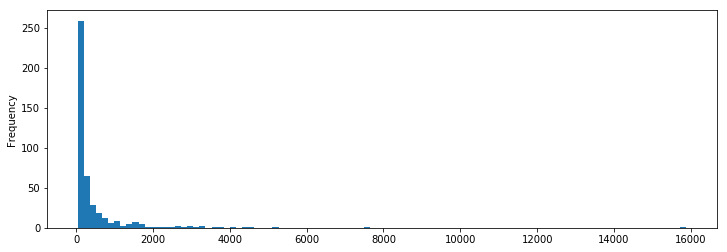

In [24]:

ecom_co_gt39_df['EMP'].plot.hist(bins=100, figsize=(12,4))

### Join ecommerce employment numbers by county with county polygon centroids

In [25]:
left_cols = ['GEOID', 'EMP']
county_ecom40_df = ecom_co_gt39_df[left_cols].set_index('GEOID').join(
                                          county_centers_df.set_index('GEOID'),
                                          lsuffix='_e' )
print('county_ecom40_df rows,cols', county_ecom40_df.shape)
county_ecom40_df.head(3)

county_ecom40_df rows,cols (439, 5)


,EMP,NAME,geometry,lat,lon
GEOID,,,,,
01003,139,Baldwin,POINT (-87.72248062937244 30.72955729828171),30.729557,-87.722481
01033,73,Colbert,POINT (-87.80168543580224 34.69847452402927),34.698475,-87.801685
01073,99,Jefferson,POINT (-86.89642646879784 33.5553835345292),33.555384,-86.896426


### Population estimates by CBSA
We want to use these population estimates to select polygons for metropolitan areas with more than 1M people as well as metropolitan areas with populations between 250k and 1M

In [26]:
pop_cbsa_2015_df = pd.read_csv('../../data/census/cbsa-est2016-alldata-alt.csv',
                               encoding='latin-1',
                               usecols=['CBSA','NAME','POPESTIMATE2015','RESIDUAL2015'],
                               dtype={'CBSA':str,
                                      'NAME':str,
                                      'POPESTIMATE2015':object,
                                      'RESIDUAL2015':object})
print('pop_cbsa_2015_df rows,cols ', pop_cbsa_2015_df.shape)
pop_cbsa_2015_df.head(3)

pop_cbsa_2015_df rows,cols  (2792, 4)


,CBSA,NAME,POPESTIMATE2015,RESIDUAL2015
0,10180,"Abilene, TX",169893,-13
1,10180,"Callahan County, TX",13596,-9
2,10180,"Jones County, TX",19972,-20


In [27]:
pop_cbsa_2015_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2792 entries, 0 to 2791
Data columns (total 4 columns):
CBSA               2789 non-null object
NAME               2790 non-null object
POPESTIMATE2015    2789 non-null object
RESIDUAL2015       2789 non-null object
dtypes: object(4)
memory usage: 87.3+ KB


In [28]:
pop_cbsa_2015_df.dropna(axis=0, inplace=True)
pop_cbsa_2015_df['CBSA'] = pop_cbsa_2015_df['CBSA'].astype('str')

In [29]:
# Remove CBSA ( CBSA consist of one or more counties ) for Alaska and Hawaii
pop_cbsa_2015_df = pop_cbsa_2015_df[np.logical_not(np.logical_or(pop_cbsa_2015_df['NAME'].str.endswith('AK'),
                                     pop_cbsa_2015_df['NAME'].str.endswith('HI')))]

In [30]:
cbsa_pop_df = us_cbsa_df.set_index('GEOID').join(pop_cbsa_2015_df.set_index('CBSA'),
                                       how='left',
                                       rsuffix='_pop')
print('cbsa_pop_df rows,cols ', cbsa_pop_df.shape)
cbsa_pop_df.head(2)

cbsa_pop_df rows,cols  (2757, 11)


,AFFGEOID,ALAND,AWATER,CBSAFP,CSAFP,LSAD,NAME,geometry,NAME_pop,POPESTIMATE2015,RESIDUAL2015
10100,310M200US10100,7352936358,111452523,10100,None,M2,"Aberdeen, SD","POLYGON ((-99.70770499999999 45.593391, -98.72...","Aberdeen, SD",42708,-20
10100,310M200US10100,7352936358,111452523,10100,None,M2,"Aberdeen, SD","POLYGON ((-99.70770499999999 45.593391, -98.72...","Brown County, SD",38699,-1


In [31]:
# Number of null values and data types per column
# You can use DataFrame.info() as well
null_df = pd.DataFrame({'number of null values': cbsa_pop_df.isnull().sum(),
                        'data type' : cbsa_pop_df.dtypes})
null_df

,data type,number of null values
AFFGEOID,object,0
ALAND,int64,0
AWATER,int64,0
CBSAFP,object,0
CSAFP,object,1052
LSAD,object,0
NAME,object,0
geometry,object,0
NAME_pop,object,20
POPESTIMATE2015,object,20


In [32]:
# Remove CSAFP column so that we can easily drop the
# population fields that contain Nan values
# These Nan values prevent me from doing a simple select on 
# field POPESTIMATE2015
cbsa_pop_df.drop(labels=['CSAFP',],
                 axis=1,
                 inplace=True)
# Drop the rows that contain Null, Nan
cbsa_pop_df.dropna(axis=0,
                   inplace=True)
cbsa_pop_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2737 entries, 10100 to 49820
Data columns (total 10 columns):
AFFGEOID           2737 non-null object
ALAND              2737 non-null int64
AWATER             2737 non-null int64
CBSAFP             2737 non-null object
LSAD               2737 non-null object
NAME               2737 non-null object
geometry           2737 non-null object
NAME_pop           2737 non-null object
POPESTIMATE2015    2737 non-null object
RESIDUAL2015       2737 non-null object
dtypes: int64(2), object(8)
memory usage: 235.2+ KB


### Create two categories large and medium CBSA

In [33]:
cbsa_pop_df['POPESTIMATE2015'] = cbsa_pop_df['POPESTIMATE2015'].astype('int')
cbsa_pop_large_df = cbsa_pop_df[cbsa_pop_df['POPESTIMATE2015'] > 999999]
cbsa_pop_medium_df = cbsa_pop_df[np.logical_and(cbsa_pop_df['POPESTIMATE2015'] > 250000,
                                 cbsa_pop_df['POPESTIMATE2015'] < 1000000)]

### List of cities and their location


In [34]:
cities_df = pd.read_csv('../../data/cities.csv')
print('cities_df rows,cols ', cities_df.shape)
cities_df.head(3)

cities_df rows,cols  (22, 5)


,city_name,long,lat,nx,ny
0,Seattle,-122.3321,47.60621,-1.5,0.0
1,Portland,-122.6765,45.52306,-1.5,0.0
2,Boise,-116.2146,43.61871,1.2,-0.5


### The column names long, lat, nx, ny are prepended with a space character

In [35]:
cities_df.columns

Index(['city_name', ' long', ' lat', ' nx', ' ny'], dtype='object')

In [36]:
cities_df.columns = ['city_name', 'long', 'lat', 'nx', 'ny']
xy = [(x,y) for x,y in zip(cities_df['long'], cities_df['lat'])]
cities_df['xy'] = xy
cities_df.head(3)

,city_name,long,lat,nx,ny,xy
0,Seattle,-122.3321,47.60621,-1.5,0.0,"(-122.3321, 47.60621)"
1,Portland,-122.6765,45.52306,-1.5,0.0,"(-122.6765, 45.52306)"
2,Boise,-116.2146,43.61871,1.2,-0.5,"(-116.2146, 43.61871)"


### Add GeoSeries type geometry column to cities dataframe

In [37]:
from shapely.geometry import Point

points = gpd.GeoSeries([Point(lon,lat) for lon,lat in zip(cities_df.long, cities_df.lat)])
cities_df['geometry'] = points
cities_df.head(3)

,city_name,long,lat,nx,ny,xy,geometry
0,Seattle,-122.3321,47.60621,-1.5,0.0,"(-122.3321, 47.60621)",POINT (-122.3321 47.60621)
1,Portland,-122.6765,45.52306,-1.5,0.0,"(-122.6765, 45.52306)",POINT (-122.6765 45.52306)
2,Boise,-116.2146,43.61871,1.2,-0.5,"(-116.2146, 43.61871)",POINT (-116.2146 43.61871)


In [38]:
target_crs = {'datum':'WGS84', 'no_defs':True, 'proj':'aea', 'lat_1':35, 'lat_2':55, 'lat_0':45, 'lon_0':10}
#<dataframe>.to_crs(crs=target_crs, inplace=True)

In [40]:
points.crs = us_cstate_df.crs
points.crs

{'init': 'epsg:4269'}

### Plot layers on state map

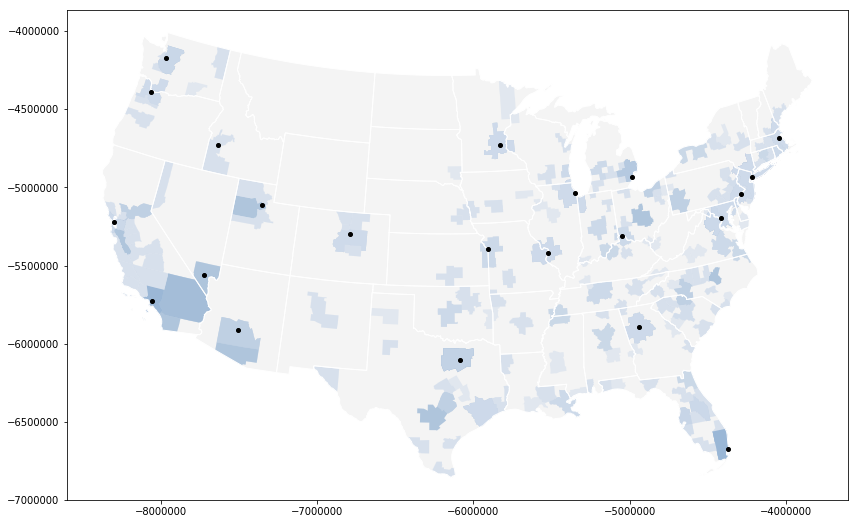

In [41]:
fig, amap = plt.subplots(1, 1, figsize = (14,12))
amap.set_aspect('equal')
angle_rot = 75
center=(-98.5795,39.8283)

# State map
us_cstate_df.to_crs(target_crs).rotate(angle=angle_rot, origin=center).plot(ax=amap,
                  linewidth = 1,
                  facecolor="#EBEBEB",
                  edgecolor="white")

cbsa_pop_large_df.to_crs(target_crs).rotate(angle=angle_rot, origin=center).plot(ax=amap,
                  linewidth = 0,
                  facecolor="#9AB7D6")

cbsa_pop_medium_df.to_crs(target_crs).rotate(angle=angle_rot, origin=center).plot(ax=amap,
                  linewidth = 0,
                  facecolor="#CFDBEB")

# Employment of 40 ecommerce workers per point by county centroid 
#emp40_markers = [amap.scatter(lon, lat, s=40,
#                              color='orange', edgecolor='white') for lon,lat,emp
#                          in zip(county_ecom40_df['lon'],
#                                 county_ecom40_df['lat'],
#                                 county_ecom40_df['EMP'])]

# City markers
points.to_crs(target_crs).rotate(angle=angle_rot, origin=center).plot(ax=amap,
                     marker='o',
                     color='black',
                     markersize=4)

# City names
#city_names = [amap.text(lon, lat, name, fontsize=10) for lon,lat,name
#              in zip(cities_df.long,cities_df.lat,cities_df.city_name)]